# Project -- Analysing IRA tweets --

In [1]:
import warnings # comment if you want to get the warnings from Searborn... 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import string
import datetime
import matplotlib.pyplot as plt
import findspark

import findspark
findspark.init()

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StringType,BooleanType
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **CONCRETE ANALYSIS**.  We summarized the most important findings since the beginning of the project in a data story like notebook. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [3]:
# taking IRAN tweets into account or not 
include_iran = False

In [4]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [5]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [6]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [7]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [8]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [9]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [10]:
# (a view is not adapted in the current context)
# tweets_stats_df.show(10)

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [11]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [12]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [14]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [15]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [16]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [17]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [18]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [19]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Furthermore, several of them are repeated and are probably faked by the troll agents. We thus consider it rather useless and prefer dropping it.

In [20]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [21]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [22]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
|Twitter for Black...|     92|
| Twitter for Windows|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [23]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [24]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [25]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [26]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [27]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [28]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [ ]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [29]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory.

## 2.  CONCRETE ANALYSIS

**SOURCE** : Tweets collected by : [about_twitter/elections-integrity](https://about.twitter.com/en_us/values/elections-integrity.html#data) 

**NOTE** : *Not all the tweets collected are trolls*. Actually all the tweets present in our database were sent by identified troll accounts (at least this is the assumption one has to make while working on this dataset) but for most of these latter they seem to have played the game cleverly. In order not to be spotted immediately as fake foreign accounts they did also manage to ressemble as any other american/russian account. Therefore there exist plenty of '*innocent*' and '*unrelated*' tweets were also written aside by troll accounts for them to pretend to be just normal.

**Main Spark SQL views**

In [30]:
# create temporary Spark SQL views of our data chunks :

# normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

# tweets_text_df
tweets_text_df.createOrReplaceTempView("tweets_text_sql")

# tweets_meta_df
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

# tweets_user_df
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

### Temporal and Quantitative analysis

For this first part of the analysis , we work most of the time on *tweet_stats* dataset .

We'll also make use of data provided by the following websites : [realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#), [wikipedia/campaign_timeline](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election).

Let's first analyze trolls *Twitter*'s activity over time. At first we take into account all the *normal_tweets* before trying to filter out non directly politically related tweets (about *Clinton*, *Trump*, *elections*, ... etc) to observe whether the overall trend is preserved. 

In [31]:
# display columns and their dtypes of normal tweets 
print((n_normal,d_normal))
normal_tweets_df.dtypes

(5441916, 13)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'timestamp'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('quote_count', 'int'),
 ('reply_count', 'int'),
 ('like_count', 'int'),
 ('retweet_count', 'int'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

Let's group *normal_tweets* by month without truncating any time window yet.

In [32]:
# group and count by month (and year)
normal_dates_query = """SELECT COUNT(tweetid) AS count, MAX(tweet_time) AS last_time
                        FROM normal_tweets_sql
                        GROUP BY YEAR(tweet_time),MONTH(tweet_time)
                        ORDER BY YEAR(tweet_time),MONTH(tweet_time) ASC
                     """
normal_dates_df = spark.sql(normal_dates_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_pd = normal_dates_df.toPandas()

normal_dates_pd[100:]

,count,last_time
100,39036,2017-10-31 23:55:00
101,3719,2017-11-30 23:13:00
102,2427,2017-12-31 21:00:00
103,1924,2018-01-31 23:50:00
104,2205,2018-02-28 23:53:00
105,1956,2018-03-31 23:34:00
106,1505,2018-04-30 23:53:00
107,1554,2018-05-31 17:02:00
108,107,2018-06-21 14:32:00


We can already observe that for some months the database doesn't contain any '*normal tweet*' ! 
Nevertheless there's actually only one month missing (August 2009) since there are 109 records and thus 108 records after the inital one whereas there would have been 109 records after May 2009 if every month was mentionned in the dataframe until June 2018

In [33]:
# recover the date of the first normal_tweet identified
start_normal_date_query = """SELECT MIN(UNIX_TIMESTAMP(tweet_time)) FROM normal_tweets_sql"""

start_normal_date = spark.sql(start_normal_date_query)
start_normal_date = start_normal_date.head()[0] # access the value of the query 

print('first normal tweet date (unix_time stamp) : ' + str(start_normal_date))
print('first normal tweet date (human readable) : '+str(pd.to_datetime(start_normal_date,unit='s')))

first normal tweet date (unix_time stamp) : 1241877540
first normal tweet date (human readable) : 2009-05-09 13:59:00


That corresponds to a tweet back in 2009 (9th of may). Of course the US 2016 presidential campaign didn't begin so early. As the reader will see, there are actually multiple *periods* of activity characterized by low/medium and high volume of tweets. 

As argued above this tweet is probably one old tweet of a '***troll account wannabe***'.

After discarding previous explanations some researches brought us on [cnbc/origins_or_IRA_dataset](https://www.cnbc.com/2018/10/17/reuters-america-update-2-twitter-publishes-tweet-trove-from-russia-iran-campaigns.html) that confirms our presumptions : all the tweets coming from the identified troll farm have been collected and gathered into the newly made available datasets. 

Let's mark down in different visual colors the 4 distinctive periods of tweets activity.

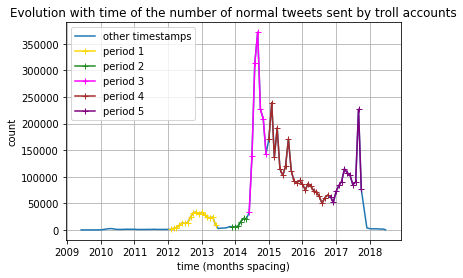

In [35]:
# plot purposes 

# period 1 

period_1_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2012,1,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2013,6,30))]

# period 2 

period_2_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2013,11,30)) & (normal_dates_pd['last_time']<=datetime.datetime(2014,5,31))]

# period 3 

period_3_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2014,5,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2014,12,31))]

# period 4

period_4_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2014,12,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2016,10,31))]

# period 5 

period_5_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2016,10,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2017,10,31))]


plt.figure(1)
plt.plot(normal_dates_pd['last_time'],normal_dates_pd['count'])
plt.plot(period_1_global_activity['last_time'],period_1_global_activity['count'],marker='+',color='gold')
plt.plot(period_2_global_activity['last_time'],period_2_global_activity['count'],marker='+',color='forestgreen')
plt.plot(period_3_global_activity['last_time'],period_3_global_activity['count'],marker='+',color='magenta')
plt.plot(period_4_global_activity['last_time'],period_4_global_activity['count'],marker='+',color='brown')
plt.plot(period_5_global_activity['last_time'],period_5_global_activity['count'],marker='+',color='purple')

plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (months spacing)')
plt.ylabel('count')
plt.legend(['other timestamps','period 1','period 2','period 3','period 4','period 5'],loc=2);

Let's have a look at the evolution with the time of the number of *troll* accounts registered.   

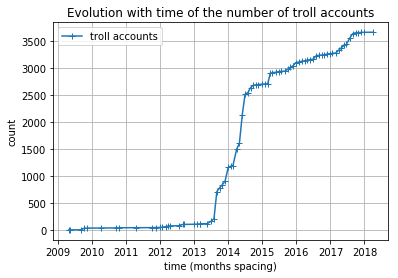

In [36]:
# group user accounts by time (month)
accounts_creation_dates_query = """SELECT MAX(account_creation_date) as last_time, COUNT(userid) as nb_users
                                    FROM tweets_user_sql
                                    GROUP BY YEAR(account_creation_date),MONTH(account_creation_date)
                                    ORDER BY YEAR(account_creation_date),MONTH(account_creation_date) ASC
                                """

accounts_creation_dates_df = spark.sql(accounts_creation_dates_query)

# small enough dataframe : it holds conveniently into Pandas for further plotting
accounts_creation_dates_pd = accounts_creation_dates_df.toPandas()

# a cumulative sum with time is required to show the evolution of the number of troll accounts
accounts_creation_dates_pd = accounts_creation_dates_pd.dropna()
accounts_creation_dates_pd.nb_users = accounts_creation_dates_pd.nb_users.cumsum()

plt.figure(1)
plt.plot(accounts_creation_dates_pd['last_time'],accounts_creation_dates_pd['nb_users'],marker='+')
plt.title('Evolution with time of the number of troll accounts')
plt.grid()
plt.xlabel('time (months spacing)')
plt.ylabel('count')
plt.legend(['troll accounts'],loc=2);

Here we give a first insight on each period and its meaning. More detailed analysis will be conducted for each period in the dedicated sections of this notebook.

**period 1 (US 2012 Elections)**

A first increasing trend is observed around 40 months after May 2009. More precisely that small, yellow, hill is located in time from February 2012 to June 2013 (increase from $\simeq 3000$ *normal_tweets* per month in February 2012 to $\simeq 34000$ in October 2012 before falling back again, smoothly, to $\simeq 2500$ in June 2013). 

Actually, this periods totally corresponds to the previous US presidential campaign for which Barack Obama had been elected president of the United States of America for the second time in a row. The observable peak of activity (October 2012) falls in the month prior to 2012's final elections. 

Taking a look at the graph showing the evolution of the number of troll accounts with time one can argue that for such a small amount of them during period 1 they had to be quite active for that campaign.  

**period 2 (Hiring Time)**

Starting from $\simeq$ mid-2013 and mostly at the beginning of 2014 one can notice a sudden increase in both the number of accounts and the troll feed activity ; those latter being obviously correlated. Looking at [wikipedia/IRA's page](https://en.wikipedia.org/wiki/Internet_Research_Agency) one can underline the job offer proposed in August 2013 : 

                                                "Internet operators wanted! ..."
                                                
The following website shed light on the early practices of IRA [wired.co.uk/twitter-trolls](https://www.wired.co.uk/article/twitter-troll-data-russia-ira-iran) Actually the initial goal of the "*agency*" was to infere on several events of the actuality (Elections, War in Ukraine, Terrorism, ... $\rightarrow$ massive opportunities). Below the reader will find multiple signs/pieces of evidence of the diversity of the actions lead by IRA's troll farm.

**period 3 (War in Donbass in full swing !)**

This time window corresponds to a massive tweet campaign of IRA to support pro-russian factions in *Donbass' war* in Ukrainia.

**period 4 (US 2016 Elections)**

(Note Ukraine's war is still undergoing at that time). 

We observe a peak starting after 61 months from May 2009, thus in June 2014. This corresponds exactly to one year prior the moment when Donald Trump announced his candidacy for the primaries (republican) [wikipedia/donald_trump](https://en.wikipedia.org/wiki/Donald_Trump#Political_activities_up_to_2015). 

This period of ***high*** activity embeds both Ukraine's war (2014-present, but its itensity reached a peak in mid-2014) and US 2016 presidential elections. 

After the peak the *troll* fever seems to drop monotically until June 2016 before growing up again **right before the final US elections** of november 2016. 

**period 5 (Ukraine's war & Presidential Instability)**

Right after the elections the activity of troll accounts isn't decreasing yet. Many contestations of the election results, transition of presidency ... etc make good troll topics. One could observe that until the end ofJanuary 2017, Trump's election wasn't confirmed yet by the congress [wikipedia/header](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election)

Trollers stop after 100 months, at the beginning of the academic year 2017-2018 (end of October 2017).

----------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------

**NOTE** :  The following sections will intensively use PySpark SQL embedded features. 

### Time window :  Period 1 (*US 2012 Elections and Vladimir Putin elections*)
Small interactions with US 2012 elections and easy to spot intra-Russia tweets about the elections.

In [37]:
# select normal tweets of the current time period 
normal_tweets_p1_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time >= "2012-02-01" AND tweet_time <= "2013-06-30"
                        """
normal_tweets_p1_df  = spark.sql(normal_tweets_p1_query)

normal_tweets_p1_df.createOrReplaceTempView("normal_tweets_p1_sql")

In [38]:
# group by week and sort by time 
normal_dates_w_p1_query =  """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                              FROM normal_tweets_p1_sql 
                              GROUP BY CAST(DATEDIFF(tweet_time,"2012-02-01")/7 AS int)
                              ORDER BY time ASC
                           """
normal_dates_w_p1_df = spark.sql(normal_dates_w_p1_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p1_pd = normal_dates_w_p1_df.toPandas()

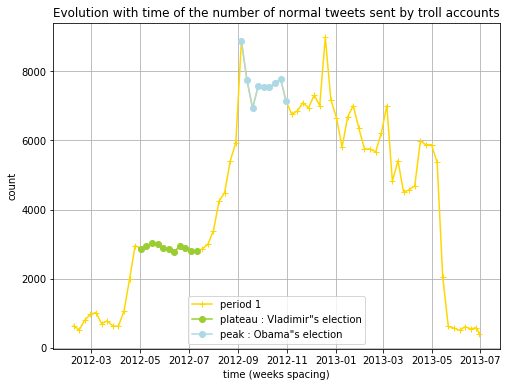

In [39]:
# plot intermediate results
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p1_pd["time"],normal_dates_w_p1_pd["count"],color="gold",marker='+')
plateau = normal_dates_w_p1_pd[(normal_dates_w_p1_pd.time>="2012-05-01") & (normal_dates_w_p1_pd.time<="2012-07-15")]
peak = normal_dates_w_p1_pd[(normal_dates_w_p1_pd.time>="2012-09-01") & (normal_dates_w_p1_pd.time<="2012-11-6")]
plt.plot(plateau["time"],plateau["count"],color="yellowgreen",marker='o')
plt.plot(peak["time"],peak["count"],color="lightblue",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 1','plateau : Vladimir"s election','peak : Obama"s election'],loc=8);

As previously highlighted a peak of activity is worth mentioning $1-2$ months before final US 2012 presidentials (light blue) 

Also one can notice a serie of saddle points/plateau (green) around May 2012 : actually looking at the most retweeted tweets for period 1 (see below) it comes to light that [wikipedia/Vladimir Putin](https://en.wikipedia.org/wiki/Vladimir_Putin) has been put forward by troll accounts at that moment.

Let's investigate tweets addressed directly to *Obama* / politics on that same time window.

In [40]:
# stop words more specifically addressed to Obama (after a review : nothing interesting embedding Clinton nor Trump)
stop_words_political_p1 = ['barack','obama','барак','обама','democrat','демократ']

In [42]:
# get texts of the normal tweets corresponding to period 1
normal_tweets_texts_p1_query = """ SELECT normal_tweets_p1_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p1_sql ON tweets_text_sql.tweetid == normal_tweets_p1_sql.tweetid
                               """

normal_tweets_texts_p1_df = spark.sql(normal_tweets_texts_p1_query)


## Parquet transformation 

# @comment if Parquet already built
# normal_tweets_texts_p1_df.write.mode('overwrite').parquet("normal_tweets_texts_p1_df")

normal_tweets_texts_p1_df = spark.read.parquet("normal_tweets_texts_p1_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p1_df.createOrReplaceTempView("normal_tweets_texts_p1_sql")

In [43]:
political_normal_tweets_texts_p1_df = normal_tweets_texts_p1_df.rdd.filter(lambda x: any(word in x.tweet_text.lower() for word in stop_words_political_p1))

# @comment if Parquet already built
# political_normal_tweets_texts_p1_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p1_df")

political_normal_tweets_texts_p1_df = spark.read.parquet("political_tweets_texts_p1_df")

In [44]:
political_normal_tweets_texts_p1_df.createOrReplaceTempView("political_tweets_texts_p1_sql")

# group by week political tweets of period 1
political_normal_dates_w_p1_query =   """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                         FROM political_tweets_texts_p1_sql 
                                         GROUP BY CAST(DATEDIFF(tweet_time,"2012-02-01")/7 AS int)
                                         ORDER BY time ASC
                                      """
political_normal_dates_w_p1_df = spark.sql(political_normal_dates_w_p1_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p1_pd = political_normal_dates_w_p1_df.toPandas()

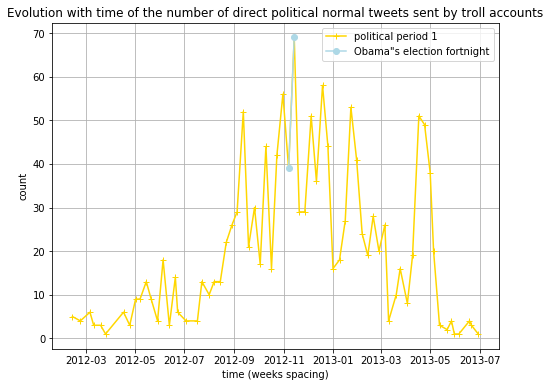

In [45]:
plt.figure(figsize=(8,6))
election_week = political_normal_dates_w_p1_pd[(political_normal_dates_w_p1_pd.time>="2012-11-01")&(political_normal_dates_w_p1_pd.time<="2012-11-20")]
plt.plot(political_normal_dates_w_p1_pd["time"],political_normal_dates_w_p1_pd["count"],color="gold",marker='+')
plt.plot(election_week["time"],election_week["count"],color='lightblue',marker='o')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 1','Obama"s election fortnight'],loc=1);

The trend is confirmed and more localized around *Obama's* election. The rest of the tweets were sent to other purposes than the US 2012 elections. As one can see, trollers from IRA are not really interested yet by US elections. As we will see there will be much more attraction for 2016's elections because of interests' conflicts between USA/RUS. 

Let's see what are the most 10 RT among those *Obama* and political tweets and their content. 

We are interested to see whether or not they already deliver hatred contents. 

In [46]:
# get the 10 (it could be more or less) most RT tweets for political period 1

political_period_1_rt_counts_top_query =     """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                                FROM political_tweets_texts_p1_sql
                                                ORDER BY retweet_count DESC
                                                LIMIT 10
                                             """
political_period_1_rt_counts_top_df = spark.sql(political_period_1_rt_counts_top_query)

# to Pandas for further analysis
political_period_1_rt_counts_top_pd = political_period_1_rt_counts_top_df.toPandas()

# quick view on the users 
political_period_1_rt_counts_top_pd

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
0,298419891134922752,449689677,8,2013-02-04 13:17:00,None,Давайте перенесемся в 1991 год. Вспомним все н...,ru,1,None
1,175859009235075072,466549101,3,2012-03-03 08:23:00,None,"""""""Когда вы будете вводить демократию с помощь...",und,0,None
2,283556556958748672,5860f89ab2d44cd6d24965203492416e263c5f607b7d63...,3,2012-12-25 12:55:00,None,Царь в моей голове отрёкся от престола. Теперь...,ru,1,[ПозитивГода]
3,265490089013022720,466549101,2,2012-11-05 16:25:00,[http://www.bbc.co.uk/russian/international/20...,А завтра United States presidential election. ...,und,0,"[USA, election]"
4,279719115969658880,2a2383f1a63d6ba732eb854df2866671632bf956322bba...,2,2012-12-14 22:46:00,[http://bit.ly/SqNvwO],Барак Обама подписал «закон Магнитского» http:...,ru,0,[новости]
5,175859572857249792,466549101,2,2012-03-03 08:26:00,None,"""""""Таким образом демократия не вводится""""""",und,0,None
6,169063653226725377,466549101,2,2012-02-13 14:21:00,None,Достигнуты договоренности о сотрудничестве с «...,und,1,None
7,266657238100353025,2a2383f1a63d6ba732eb854df2866671632bf956322bba...,2,2012-11-08 21:43:00,[http://bit.ly/Z8nXUt],Обама посетит Россию в 2013 году http://t.co/v...,und,0,[новости]
8,333246665635004416,466549101,2,2013-05-11 15:46:00,[http://mobile.bbc.co.uk/russian/international...,Первые демократические #выборы в #Пакистан'е п...,ru,0,"[выборы, Пакистан]"
9,281007664950034433,aa6d42bfd479088dd39ad698cb7a465be95403eb34720a...,2,2012-12-18 12:07:00,None,"Единый день голосования - вот где демократия,...",ru,0,[БолотныйТупик]


In [47]:
# print plain tweet text 
iterator = 1
for elem in political_period_1_rt_counts_top_pd['tweet_text']:
    print(iterator)
    iterator=iterator+1
    print(elem)

1
Давайте перенесемся в 1991 год. Вспомним все надежды, на демократию, Ельцина, радость от краха КПСС, и посмотрим на нашу действительность.
2
"""Когда вы будете вводить демократию с помощью оружия
3
Царь в моей голове отрёкся от престола. Теперь у меня демократия #ПозитивГода
4
А завтра United States presidential election. Рейтинги @BarackObama и @MittRomney практически равны http://t.co/abBeWx5z #USA #election
5
Барак Обама подписал «закон Магнитского» http://t.co/y7uYSKT1 #новости
6
"""Таким образом демократия не вводится"""
7
Достигнуты договоренности о сотрудничестве с «Лигой избирателей», «Демократической правовой Россией», «Открытой трибуной», обществ.деятелями
8
Обама посетит Россию в 2013 году http://t.co/vATDhr36 #новости
9
Первые демократические #выборы в #Пакистан'е прошли на фоне взрывов и стрельбы. Власти отмечают высокую явку http://t.co/r2ezTHKvLA
10
Единый день голосования  - вот где демократия, вот где нужно было вступать в конфронтацию с властью #БолотныйТупик


Translation of symbolic tweets : 

-  first tweet : "*Let's fast forward to 1991. Recall all hopes for democracy, Yeltsin, the joy of the collapse of the CPSU, and look at our reality.*"
- second tweet : "*When will you introduce democracy with weapons?*"
- nineth tweet : "*Obama fell off his bike and suffered responsibility for the & lt; & lt; terrorist attack & gt; & gt; a terrorist group from & lt; & lt; Al-Qaida;*"

Not all the tweets are related to Obama (some are about russian feelings) but the ones highlighted above are quite expressive. 
Trollers often use gross/violent language and send content of hate sometimes ($9th$ tweet).

### Time window : Period 2 (*Hiring Time*)

Recall : we observe increasing troll activity immediately time-correlated to the start of the well known armed conflict in Ukrainia. The semantic analysis performed above already showed the overall support tweets from IRA tried to send through. 

In [48]:
# select normal tweets of the current time period 
normal_tweets_p2_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2013-11-30" AND tweet_time <= "2014-05-31"
                        """
normal_tweets_p2_df  = spark.sql(normal_tweets_p2_query)

normal_tweets_p2_df.createOrReplaceTempView("normal_tweets_p2_sql")

In [49]:
# group by week and sort by time 
normal_dates_w_p2_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p2_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2013-12-01")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p2_df = spark.sql(normal_dates_w_p2_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p2_pd = normal_dates_w_p2_df.toPandas()

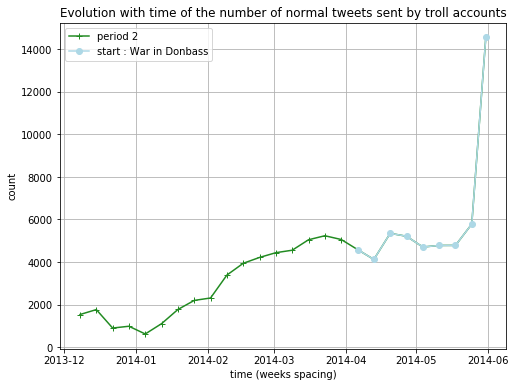

In [50]:
# plot intermediate results
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p2_pd["time"],normal_dates_w_p2_pd["count"],color="forestgreen",marker='+')
war = normal_dates_w_p2_pd[(normal_dates_w_p2_pd.time>="2014-04-01")]
plt.plot(war["time"],war["count"],color="lightblue",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 2','start : War in Donbass'],loc=2);

As [wikipedia/war in Donbass](https://en.wikipedia.org/wiki/War_in_Donbass) tells us. Ukraine's armed conflict started around March-April 2014, then with some latency trollers began their job apparently. Prior to those events a calm period had been observed, Ukrain's troubles seemed to trigger the trollers again.  

### Time window :  Period 3 (*War in Donbass*)

@comment

### Time window :  Period 4 (*US 2016 Elections*)

Let's now focus on the period of time corresponding to the whole presidential campaign (+ some time before as a flourishing speculative period)

In [51]:
# select normal tweets of the current time period 
normal_tweets_p4_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2014-12-31" AND tweet_time <= "2016-11-07"
                        """
normal_tweets_p4_df  = spark.sql(normal_tweets_p4_query)

normal_tweets_p4_df.createOrReplaceTempView("normal_tweets_p4_sql")

In [52]:
# group by week and sort by time 
normal_dates_w_p4_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p4_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2014-12-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p4_df = spark.sql(normal_dates_w_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p4_pd = normal_dates_w_p4_df.toPandas()

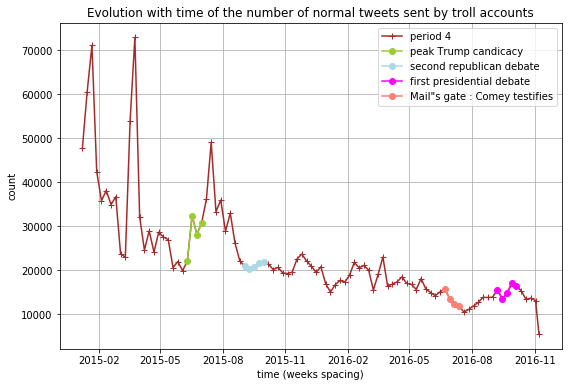

In [78]:
# plot intermediate results

# /!\ occured the 6th of June 2015
peak_candidacy_trump = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2015-06-09") & (normal_dates_w_p4_pd.time<="2015-07-02")]

# /!\ second republican debate held on 16th of Sep 2015
peak_second_debate = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2015-09-01") & (normal_dates_w_p4_pd.time<="2015-10-02")]

# /!\ first presidential debate (after primaires) on the 26 of september 
peak_first_pres_debate = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2016-09-04") & (normal_dates_w_p4_pd.time<="2016-10-05")]

# /!\ Senate probes Loretta Lynch interference (Wikipedia) => H. Clinton's mails gate
peak_mail_gate = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2016-06-15") & (normal_dates_w_p4_pd.time<="2016-07-15")]

plt.figure(figsize=(9,6))
plt.plot(normal_dates_w_p4_pd["time"],normal_dates_w_p4_pd["count"],color="brown",marker='+')
plt.plot(peak_candidacy_trump["time"],peak_candidacy_trump["count"],color='yellowgreen',marker='o')
plt.plot(peak_second_debate["time"],peak_second_debate["count"],color='lightblue',marker='o')
plt.plot(peak_first_pres_debate["time"],peak_first_pres_debate["count"],color='magenta',marker="o")
plt.plot(peak_mail_gate["time"],peak_mail_gate["count"],color="salmon",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 4','peak Trump candicacy','second republican debate','first presidential debate','Mail"s gate : Comey testifies'],loc=1);

(For the explanation of the detected peaks, please refer to the second graph about directly politically related tweets.)

We can see that peaks of the second graph do not always match with the most prominent peaks within the overall frequency distribution of troll tweets (presence of other topics !)

In [54]:
# get texts of the normal tweets corresponding to period 4
normal_tweets_texts_p4_query = """ SELECT normal_tweets_p4_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p4_sql ON tweets_text_sql.tweetid == normal_tweets_p4_sql.tweetid
                               """

normal_tweets_texts_p4_df = spark.sql(normal_tweets_texts_p4_query)

## Parquet transformation 

# @comment if Parquet already built
#normal_tweets_texts_p4_df.write.mode('overwrite').parquet("normal_tweets_texts_p4_df")

normal_tweets_texts_p4_df = spark.read.parquet("normal_tweets_texts_p4_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p4_df.createOrReplaceTempView("normal_tweets_texts_p4_sql")

Let's now investigate the correlations between events of actuality and short period aggregated troll tweets counts (overall and/or politically related). 

In order to detect politically related tweets we also need to store some obvious stop words.

In [55]:
stop_words_political = ['donald','trump','дональд','трамп','hillary','clinton','хиллари','клинтон',\
                        'barack','obama','барак','обама','republican','республиканец','democrat','демократ',\
                        'presidential','elections','выборы','президента','votes','голосов','fake news','fakenews','поддельные',\
                       'новости']

In [56]:
# filter with political stop words 
political_normal_tweets_texts_p4_df = normal_tweets_texts_p4_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
# political_normal_tweets_texts_p4_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p4_df")

political_normal_tweets_texts_p4_df = spark.read.parquet("political_tweets_texts_p4_df")

In [57]:
political_normal_tweets_texts_p4_df.createOrReplaceTempView("political_normal_tweets_p4_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p4_query =   """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                         FROM political_normal_tweets_p4_sql 
                                         GROUP BY CAST(DATEDIFF(tweet_time,"2014-12-31")/7 AS int)
                                         ORDER BY time ASC
                                      """
political_normal_dates_w_p4_df = spark.sql(political_normal_dates_w_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p4_pd = political_normal_dates_w_p4_df.toPandas()

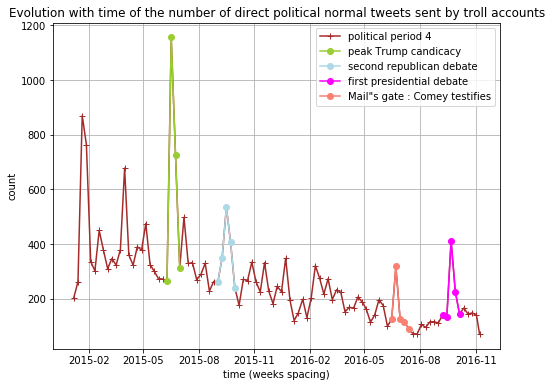

In [77]:
# plotting time

# /!\ occured the 6th of June 2015
peak_candidacy_trump = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2015-06-09") & (political_normal_dates_w_p4_pd.time<="2015-07-02")]

# /!\ second republican debate held on 16th of Sep 2015
peak_second_debate = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2015-09-01") & (political_normal_dates_w_p4_pd.time<="2015-10-02")]

# /!\ first presidential debate (after primaires) on the 26 of september 
peak_first_pres_debate = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2016-09-04") & (political_normal_dates_w_p4_pd.time<="2016-10-05")]

# /!\ Senate probes Loretta Lynch interference (Wikipedia) => H. Clinton's mails gate
peak_mail_gate = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2016-06-10") & (political_normal_dates_w_p4_pd.time<="2016-07-15")]

plt.figure(figsize=(8,6))
plt.plot(political_normal_dates_w_p4_pd["time"],political_normal_dates_w_p4_pd["count"],color="brown",marker='+')
plt.plot(peak_candidacy_trump["time"],peak_candidacy_trump["count"],color='yellowgreen',marker='o')
plt.plot(peak_second_debate["time"],peak_second_debate["count"],color='lightblue',marker='o')
plt.plot(peak_first_pres_debate["time"],peak_first_pres_debate["count"],color='magenta',marker='o')
plt.plot(peak_mail_gate["time"],peak_mail_gate["count"],color="salmon",marker='o')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 4','peak Trump candicacy','second republican debate','first presidential debate','Mail"s gate : Comey testifies'],loc=1);

We have succeeded in spotting some peaks immediately related to campaign's events ! 

Now, in order to get a **qualitative** effect of the trolls tweets we will display : 

                - intentions of vote (polls) and directly politically related tweets vs. time
                
and in order to get a **quantitatitve** effect of the prolls tweets we compute :

                 - aggregated sentimental scores per week and per opponent (Trump vs. Clinton).

Since this is the period that interests us the most to talk about we scrapped data from a popularity/intention of votes analysis from . We put side to side the volume of direct political troll tweets and the polls ([realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#) starting within the primaries of US 2016 elections) for both H. Clinton and D.J Trump. 

In [59]:
# import intentions of vote during and after primaries
ap_clinton_trump_votes = pd.read_excel(DATA_DIR+'trump_hillary.xlsx')

In [60]:
# time spacing with 1st of april (date for which our dataset scrapped begins)
datelist = pd.date_range("2016-04-01", periods=221).tolist()

In [61]:
# focus on the last months (days) of the elections (only getting direct politically related tweets) 
political_normal_dates_ap_d_p4_query =    """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                             FROM political_normal_tweets_p4_sql 
                                             WHERE tweet_time >="2016-03-01"
                                             GROUP BY YEAR(tweet_time),MONTH(tweet_time),DAY(tweet_time)
                                             ORDER BY YEAR(tweet_time),MONTH(tweet_time),DAY(tweet_time) ASC
                                          """
political_normal_dates_ap_d_p4_df = spark.sql(political_normal_dates_ap_d_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_ap_d_p4_pd = political_normal_dates_ap_d_p4_df.toPandas()

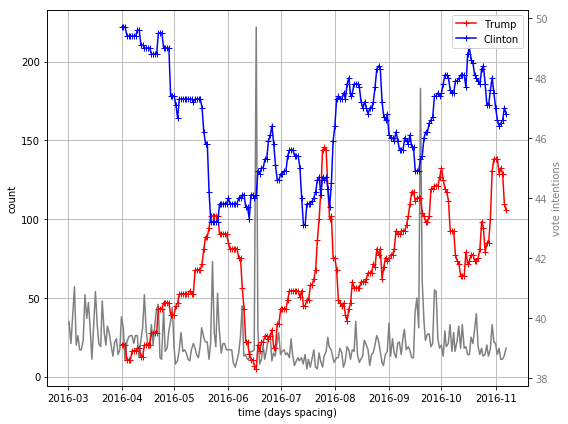

Vote Intentions & Directly Politically related Tweets vs. Time


In [62]:
# https://matplotlib.org/gallery/api/two_scales.html

fig, ax1 = plt.subplots(figsize=(8,6))

color = 'grey'
ax1.set_xlabel('time (days spacing)')
ax1.set_ylabel('count', color= "black")
ax1.plot(political_normal_dates_ap_d_p4_pd['time'], political_normal_dates_ap_d_p4_pd['count'], color='grey')
ax1.tick_params(axis='y', labelcolor="black")

ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis

ax2.set_ylabel('vote intentions', color=color) 
ax2.plot(datelist,ap_clinton_trump_votes['Trump'], color="red",marker='+')
ax2.plot(datelist,ap_clinton_trump_votes['Hillary'], color="blue",marker='+')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Trump','Clinton'],loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('Vote Intentions & Directly Politically related Tweets vs. Time')

Unfortunately we cannot assess a direct link between politically related tweets (in overall) and the intention of votes... 
A lot of different social media sources must be taken into account, it's really hard to get significant results only based on the given datasets. Most of the interesting statistics about social influence / popularity scores ... etc are chargeable (you must pay for them), also we should have had access to studies (for instance the studies used by [paper/AllCott-US2016-fakeNews](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.211) to get an insight on how are people affected by the presence of the well established troll tweets. 

The existence of trolls is undeniable (examples are to follow below) but their spread to american citizens (or more globally, for all tweets' topics, human beings) is really tough. Nevertheless we can try to quantify the hatred leaning of the tweets themselves ; it will give us informations about how ***could*** be affected the people who read them ! 

Here below one can find, along a timeline, the results of the *vader* sentimental analysis. 

In [63]:
# read of Parquet files about sentiment analysis => only reported english written tweets

neg_hillary_vader = spark.read.parquet("neg_hillary_vader")
neg_trump_vader = spark.read.parquet("neg_trump_vader")
neg_obama_vader = spark.read.parquet("neg_obama_vader")

pos_hillary_vader = spark.read.parquet("pos_hillary_vader")
pos_trump_vader = spark.read.parquet("pos_trump_vader")
pos_obama_vader = spark.read.parquet("pos_obama_vader")

After the sentimental analysis of tweets written in **english** : 
- identified (positively or negatively) troll tweets about either *D.J. Trump*, *B. Obama* and *H. Clinton* are joined to their user, retweet_counts, ... etc 

In [64]:
def rejoin_query(name):
    return """SELECT normal_tweets_sql.tweetid,userid,tweet_time,in_reply_to_userid,quoted_tweet_tweetid,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices FROM normal_tweets_sql JOIN """ +name+ " ON normal_tweets_sql.tweetid == "+name+".tweetid"

neg_hillary_vader.createOrReplaceTempView("neg_hillary_vader_sql")
neg_trump_vader.createOrReplaceTempView("neg_trump_vader_sql")
neg_obama_vader.createOrReplaceTempView("neg_obama_vader_sql")

pos_hillary_vader.createOrReplaceTempView("pos_hillary_vader_sql")
pos_trump_vader.createOrReplaceTempView("pos_trump_vader_sql")
pos_obama_vader.createOrReplaceTempView("pos_obama_vader_sql")

## HILLARY CLINTON 

neg_hillary_vader_df = spark.sql(rejoin_query("neg_hillary_vader_sql"))
# @comment if Parquet already built
#neg_hillary_vader_df.write.mode('overwrite').parquet("neg_hil_vader")
neg_hillary_vader_df = spark.read.parquet("neg_hil_vader")

pos_hillary_vader_df = spark.sql(rejoin_query("pos_hillary_vader_sql"))
# @comment if Parquet already built
#pos_hillary_vader_df.write.mode('overwrite').parquet("pos_hil_vader")
pos_hillary_vader_df = spark.read.parquet("pos_hil_vader")

## BARACK OBAMA

neg_obama_vader_df = spark.sql(rejoin_query("neg_obama_vader_sql"))
# @comment if Parquet already built
#neg_obama_vader_df.write.mode('overwrite').parquet("neg_oba_vader")
neg_obama_vader_df = spark.read.parquet("neg_oba_vader")

pos_obama_vader_df = spark.sql(rejoin_query("pos_obama_vader_sql"))
# @comment if Parquet already built
#pos_obama_vader_df.write.mode('overwrite').parquet("pos_oba_vader")
pos_obama_vader_df = spark.read.parquet("pos_oba_vader")

## DONALD TRUMP

neg_trump_vader_df = spark.sql(rejoin_query("neg_trump_vader_sql"))
# @comment if Parquet already built
#neg_trump_vader_df.write.mode('overwrite').parquet("neg_tru_vader")
neg_trump_vader_df = spark.read.parquet("neg_tru_vader")

pos_trump_vader_df = spark.sql(rejoin_query("pos_trump_vader_sql"))
# @comment if Parquet already built
#pos_trump_vader_df.write.mode('overwrite').parquet("pos_tru_vader")
pos_trump_vader_df = spark.read.parquet("pos_tru_vader")

Let's sort and group them by week using integrated/built-in Panda's time window slicer. 

In [65]:
grouped_pos_hillary_vader_w_pd = pos_hillary_vader_df.select(pos_hillary_vader_df.tweet_time,pos_hillary_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_hillary_vader_w_pd = neg_hillary_vader_df.select(neg_hillary_vader_df.tweet_time,neg_hillary_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

grouped_pos_obama_vader_w_pd = pos_obama_vader_df.select(pos_obama_vader_df.tweet_time,pos_obama_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_obama_vader_w_pd = neg_obama_vader_df.select(neg_obama_vader_df.tweet_time,neg_obama_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

grouped_pos_trump_vader_w_pd = pos_trump_vader_df.select(pos_trump_vader_df.tweet_time,pos_trump_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_trump_vader_w_pd = neg_trump_vader_df.select(neg_trump_vader_df.tweet_time,neg_trump_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

Now we are all set-up to make all the necessary plots for the temporal analysis of the sentimental analysis. 

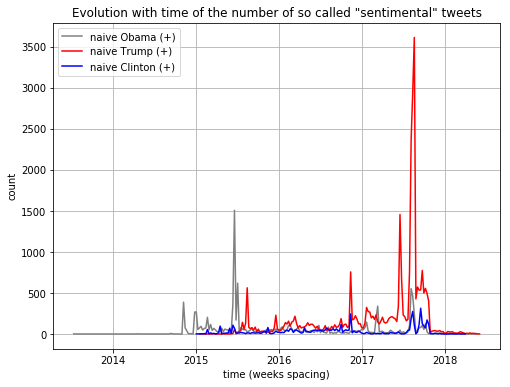

In [66]:
# global evolution of sentiment analysis => positive identified tweets for Clinton, Obama, Trump
plt.figure(figsize=(8,6))
plt.plot(grouped_pos_obama_vader_w_pd,color="grey",ls="-")
plt.plot(grouped_pos_trump_vader_w_pd,color="red",ls="-")
plt.plot(grouped_pos_hillary_vader_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['naive Obama (+)','naive Trump (+)','naive Clinton (+)'],loc=2);

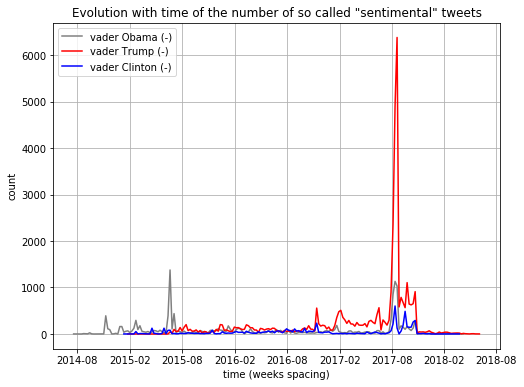

In [67]:
# global evolution of sentiment analysis => negative identified tweets for Clinton, Obama, Trump
plt.figure(figsize=(8,6))
plt.plot(grouped_neg_obama_vader_w_pd,color="grey",ls="-")
plt.plot(grouped_neg_trump_vader_w_pd,color="red",ls="-")
plt.plot(grouped_neg_hillary_vader_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
#plt.legend(['naive Obama','naive Trump','naive Clinton'],loc=2);
plt.legend(['vader Obama (-)','vader Trump (-)','vader Clinton (-)'],loc=2);

The *sentiment delta* is the difference between the counted *vader*-positive tweets for a candidate and the counted *vader*-negative tweets . 

As a reminder, *vader* is the tool used for our sentimental analysis : [github/vader](https://github.com/cjhutto/vaderSentiment)

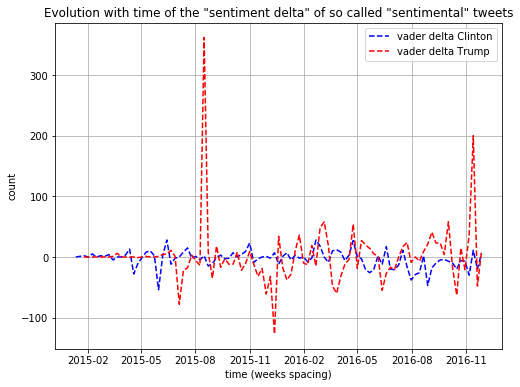

In [68]:
# get the difference between weekly aggregated sentimentally positive and negative number of troll tweets
delta_vader_trump_elections = grouped_pos_trump_vader_w_pd-grouped_neg_trump_vader_w_pd
delta_vader_hillary_elections = grouped_pos_hillary_vader_w_pd-grouped_neg_hillary_vader_w_pd
 
plt.figure(figsize=(8,6))
plt.plot(delta_vader_hillary_elections.loc[:"2016-12-01"],color="blue",ls="--")
plt.plot(delta_vader_trump_elections.loc[:"2016-12-01"],color="red",ls="--")
plt.title('Evolution with time of the "sentiment delta" of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['vader delta Clinton','vader delta Trump'],loc=1);

Focusing on the entire US 2016 presidential campaign and looking at summary statistics, we actually find out that *Trump* is slightly supported by the troll tweets with respect to Hillary which is, in average, disapproved.

Of course, one has to remain careful while reading those stats since the undertaken sentimental analysis isn't a pure science yet : quite heuristic!

For instance, the trends are too hard to catch and we cannot really tell *how did the strategy of troll accounts vary over time*.

In [69]:
delta_vader_hillary_elections.loc[:"2016-12-01"].describe()

,tweetid
count,99.000000
mean,-3.151515
std,14.054822
min,-54.000000
25%,-9.500000
50%,0.000000
75%,3.000000
max,28.000000


In [70]:
delta_vader_trump_elections.loc[:"2016-12-01"].describe()

,tweetid
count,97.000000
mean,1.525773
std,50.821192
min,-127.000000
25%,-17.000000
50%,0.000000
75%,10.000000
max,362.000000


Let's get some basic statistics about the feature *retweet_count* of the *normal_tweets* of the current period. 

Again, we would like to evaluate/assess the importance of troll tweets. We do not dispose of view counts for such tweets but what can be sure about is that there exists a correlation between the number of views and the number of retweets (the more a post is retweeted, the more likely that it reaches more and more people across the internet).

Summary statistics of *retweet_count*  vs. statistics of typical 'popular' tweets on Twitter to get a kind of 'popularity scale'. Of course we have to be careful with the data we're dealing with : there might be some automatic retweet nested chains that would bias those results. We conducted some experiments about the links of troll accounts between them by a graph-links analysis. 

In [71]:
# get only the retweets counts 
period_4_rt_counts_query = """SELECT retweet_count AS retweets
                              FROM normal_tweets_p4_sql
                           """
period_4_rt_counts_df = spark.sql(period_4_rt_counts_query)

# relative error tolerance for median computation 
tol = 0.001

print('Summary statistics for RT counts for period 4 normal_tweets : ')
print('--------------------------------------------------------------')
period_4_rt_counts_df.select('retweets').describe().show()
print('approx. 1st quarter quantile : '+str(period_4_rt_counts_df.approxQuantile('retweets',[0.25],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. median : '+str(period_4_rt_counts_df.approxQuantile('retweets',[0.5],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. 3rd quarter quantile : '+str(period_4_rt_counts_df.approxQuantile('retweets',[0.75],tol)[0])+\
      ' for relative error of '+str(tol))

Summary statistics for RT counts for period 4 normal_tweets : 
--------------------------------------------------------------
+-------+-----------------+
|summary|         retweets|
+-------+-----------------+
|  count|          2250731|
|   mean|5.028659133410434|
| stddev|99.28903534679117|
|    min|                0|
|    max|            97498|
+-------+-----------------+

approx. 1st quarter quantile : 0.0 for relative error of 0.001
approx. median : 0.0 for relative error of 0.001
approx. 3rd quarter quantile : 1.0 for relative error of 0.001


$\Rightarrow$  *stddev* is huge and mean is well above 3rd quantile, those statistics seem to indicate a ***power law*** distribution. 

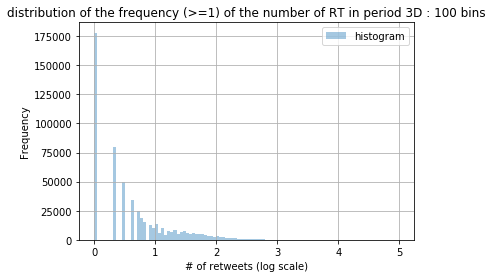

In [79]:
# let's discover the number of normal tweets that were RT more than 10 times for this period
period_4_rt_counts_sup1_query = """SELECT retweet_count AS retweets
                                   FROM normal_tweets_p4_sql
                                   WHERE retweet_count>=1
                                """
period_4_rt_counts_sup1_df = spark.sql(period_4_rt_counts_sup1_query)

# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(period_4_rt_counts_sup1_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('distribution of the frequency (>=1) of the number of RT in period 3D : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

Among the tweets RT more than $x=10$ times, we can observe the tail under the scope of a zoom ! 

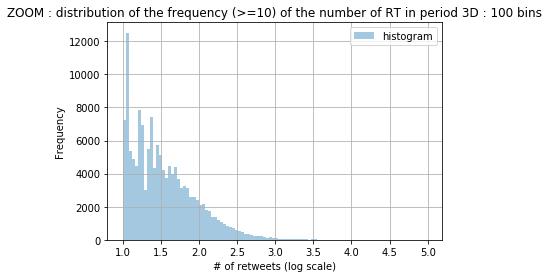

In [80]:
# let's discover the number of normal tweets that were RT more than 10 times for this period
period_4_rt_counts_sup10_query = """SELECT retweet_count AS retweets
                                    FROM normal_tweets_p4_sql
                                    WHERE retweet_count>=10 
                                 """
period_4_rt_counts_sup10_df = spark.sql(period_4_rt_counts_sup10_query)

# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(period_4_rt_counts_sup10_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('ZOOM : distribution of the frequency (>=10) of the number of RT in period 3D : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

Unfortunately, troll tweets don't seem to differ from the general shape of the frequency count of RT of tweets. 

Indeed, it's actually a well known fact that RT counts follow power laws [paper/example](https://www.sciencedirect.com/science/article/pii/S1877050914005006) , [paper/another_example](https://dl.acm.org/citation.cfm?id=3053903&dl=ACM&coll=DL). 

That being said, it can be interesting to extract the most RT normal tweets and have a look at their content (we keep the *tweetid*'s). 

In [81]:
# get the 1000 (it could be more or less) most RT tweets for period 4

period_4_rt_counts_top_query =     """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                      FROM normal_tweets_texts_p4_sql
                                      ORDER BY retweet_count DESC
                                      LIMIT 1000
                                   """
period_4_rt_counts_top_df = spark.sql(period_4_rt_counts_top_query)

# create temporary Spark SQL view 
period_4_rt_counts_top_df.createOrReplaceTempView("period_4_rt_counts_top_sql")

period_4_rt_counts_top_df.show(10)

+------------------+----------+-------------+-------------------+----+--------------------+--------------+----------+--------------------+
|           tweetid|    userid|retweet_count|         tweet_time|urls|          tweet_text|tweet_language|like_count|            hashtags|
+------------------+----------+-------------+-------------------+----+--------------------+--------------+----------+--------------------+
|780901314079318016|4437233895|        97498|2016-09-27 22:45:00|  []|These emotions......|            en|    136013|                  []|
|785614679682846720|4437233895|        41089|2016-10-10 22:55:00|  []|When It’s slowly ...|            en|     46606|      [BlackTwitter]|
|710499812223918080|3312143142|        28568|2016-03-17 16:15:00|  []|!!!!!!DONT LET TH...|            en|     17639|                  []|
|711543567387332608|3312143142|        25169|2016-03-20 13:23:00|  []|He didn’t want a ...|            en|     14748|                  []|
|708741988481282048|3312143

In [82]:
# get the 1000 (it could be more or less) most RT tweets for period 4 || after primaries and before final votes

ap_period_4_rt_counts_top_query =  """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                      FROM normal_tweets_texts_p4_sql
                                      WHERE tweet_time >= "2016-07-07"
                                      ORDER BY retweet_count DESC
                                      LIMIT 1000
                                   """
ap_period_4_rt_counts_top_df = spark.sql(ap_period_4_rt_counts_top_query)

# create temporary Spark SQL view 
ap_period_4_rt_counts_top_df.createOrReplaceTempView("ap_period_4_rt_counts_top_sql")

# to Pandas for further analysis
ap_period_4_rt_counts_top_pd = ap_period_4_rt_counts_top_df.toPandas()

ap_period_4_rt_counts_top_pd.head(10)

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
0,780901314079318016,4437233895,97498,2016-09-27 22:45:00,[],These emotions... You can hear the pain in her...,en,136013,[]
1,785614679682846720,4437233895,41089,2016-10-10 22:55:00,[],When It’s slowly becoming illegal for black pe...,en,46606,[BlackTwitter]
2,784182493868023808,4437233895,16627,2016-10-07 00:04:00,[],Normal??? Anti-racism poster gone horribly wr...,en,15020,[]
3,777989058689536000,4437233895,16104,2016-09-19 21:53:00,[],"""""""His life mattered."""" #TerenceCrutcher's t...",en,15185,[TerenceCrutcher]
4,793890171058085888,4224729994,15548,2016-11-02 18:59:00,[],BREAKING: #VoterFraud by counting tens of thou...,en,10172,[VoterFraud]
5,792117761631588352,4437233895,14433,2016-10-28 21:36:00,[],Bus driver sexually assaulted teen girl. Black...,en,10772,[]
6,778619154660204544,1687183549,13316,2016-09-21 15:37:00,[],Wow. Hadn't thought of it that way but that's ...,en,11709,[BlackLivesMatter]
7,785663973613899776,4224729994,12716,2016-10-11 02:11:00,[],"OMG, this new Anti-Hillary ad is brilliant!👌 I...",en,10756,[]
8,790699646096056321,4437233895,11838,2016-10-24 23:41:00,[],Let this picture sink in. Maximize it. Zoom in...,en,7419,[]
9,788450633896562689,4224729994,10824,2016-10-18 18:44:00,[],RT the hell out of it: Dem party operatives: ...,en,6772,[EvangelicalTrump]


In [83]:
ap_period_4_rt_counts_top_pd.loc[7]['tweet_text']

"OMG, this new Anti-Hillary ad is brilliant!👌 It's fantastic!!!!!!  Spread it far &amp; wide! https://t.co/v7zrP8iDl7"

In [84]:
# interesting account
troll_example_p4 = ap_period_4_rt_counts_top_pd[ap_period_4_rt_counts_top_pd.userid=='4224729994']

In [85]:
troll_example_p4.shape

(567, 9)

$56.8\%$ of the 1000 (and $47\%$ of the 100) most RT tweets on the period (July 2016 - November 2016 ; after primaries before final votes) are written by only one troll account ! 

In [86]:
troll_example_p4

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
4,793890171058085888,4224729994,15548,2016-11-02 18:59:00,[],BREAKING: #VoterFraud by counting tens of thou...,en,10172,[VoterFraud]
7,785663973613899776,4224729994,12716,2016-10-11 02:11:00,[],"OMG, this new Anti-Hillary ad is brilliant!👌 I...",en,10756,[]
9,788450633896562689,4224729994,10824,2016-10-18 18:44:00,[],RT the hell out of it: Dem party operatives: ...,en,6772,[EvangelicalTrump]
14,788978081293819904,4224729994,9323,2016-10-20 05:40:00,[],BREAKING🚨 Hillary shuts down press conferenc...,en,8927,"[VoterFraud, debatenight, TrumpBookReport]"
16,788532197506572296,4224729994,8574,2016-10-19 00:08:00,[],BREAKING🚨 Thousands of names changed on voter...,en,7092,"[VoterFraud, DrainTheSwamp]"
23,788169033841577985,4224729994,6676,2016-10-18 00:05:00,[],OMFG! This is EXPLOSIVE! THE MOST IMPORTANT V...,en,4218,[BillyBushMadeMeDoIt]
25,788098438915297280,4224729994,6303,2016-10-17 19:24:00,[],"""This is sickening. Hillary using the """"Mental...",en,4573,"[FreeJulian, BirdDogging, PodestaEmails10]"
29,792802334602592258,4224729994,5799,2016-10-30 18:56:00,[],RT if you also think that @LorettaLynch should...,en,5210,[gohillary]
32,783728674390544384,4224729994,5058,2016-10-05 18:00:00,[],BREAKING🚨 Hillary caught using a child actor‼️...,en,3413,[WorldTeachersDay]
35,785621909677285376,4224729994,4708,2016-10-10 23:23:00,[],""".@AnnCoulter: """"If Hillary wins",en,4857,[]


### Time window : Period 5 (*Ukraine's War & Presidential Instability*)

In this time window we did observe two main events that pushed massively troll accounts to their keyboards ! 

In [87]:
# get the corresponding tweets for period 5
normal_tweets_p5_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2016-10-31" AND tweet_time <= "2017-10-31"
                        """
normal_tweets_p5_df  = spark.sql(normal_tweets_p5_query)

normal_tweets_p5_df.createOrReplaceTempView("normal_tweets_p5_sql")

In [88]:
# group and count by weeks (only the weeks of interest corresponding to the current time window) 
normal_dates_w_p5_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p5_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2016-10-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p5_df = spark.sql(normal_dates_w_p5_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p5_pd = normal_dates_w_p5_df.toPandas()

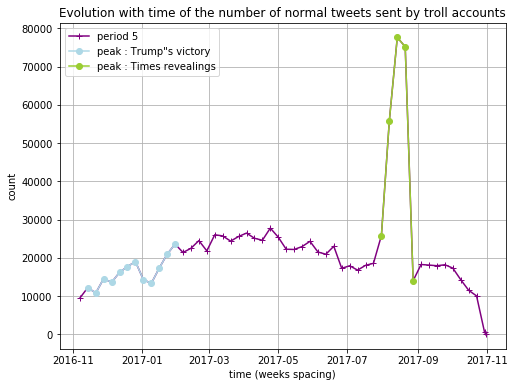

In [89]:
plt.figure(figsize=(8,6))

# /!\ occured the 8th of November 2016 => we keep counts even for January 2017 since the investiture occurs in 2017 and 
# the transition time between the efficient transfer power was a really 'hectic' time
peak_victory = normal_dates_w_p5_pd[(normal_dates_w_p5_pd.time>="2016-11-08") & (normal_dates_w_p5_pd.time<="2017-01-31")]

# /!\ Times' revealings
peak_gate = normal_dates_w_p5_pd[(normal_dates_w_p5_pd.time>="2017-07-25") & (normal_dates_w_p5_pd.time<="2017-08-31")]

plt.plot(normal_dates_w_p5_pd["time"],normal_dates_w_p5_pd["count"],color="purple",marker='+')
plt.plot(peak_victory["time"],peak_victory["count"],color="lightblue",marker='o')
plt.plot(peak_gate["time"],peak_gate["count"],color="yellowgreen",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 5','peak : Trump"s victory','peak : Times revealings'],loc=2);

On this graph, *Trump's* win for US2016 elections isn't noticeable : one more time this supports the thesis for which IRA troll farm isn't only focusing on the american elections : there's so much more at stake ! Again '*war*' in Ukrain is still undergoing in the background and that's why the troll tweets volume seem to be rather stable despite the victory of Trump. We discuss the huge peak of July 2017 below ! 

In [90]:
# get texts of the normal tweets corresponding to period 5
normal_tweets_texts_p5_query = """ SELECT normal_tweets_p5_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p5_sql ON tweets_text_sql.tweetid == normal_tweets_p5_sql.tweetid
                               """

normal_tweets_texts_p5_df = spark.sql(normal_tweets_texts_p5_query)


## Parquet transformation 

# @comment if Parquet already built
#normal_tweets_texts_p5_df.write.mode('overwrite').parquet("normal_tweets_texts_p5_df")

normal_tweets_texts_p5_df = spark.read.parquet("normal_tweets_texts_p5_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p5_df.createOrReplaceTempView("normal_tweets_texts_p5_sql")


In [91]:
political_normal_tweets_texts_p5_df = normal_tweets_texts_p5_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
#political_normal_tweets_texts_p5_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p5_df")

political_normal_tweets_texts_p5_df = spark.read.parquet("political_tweets_texts_p5_df")

In [92]:
political_normal_tweets_texts_p5_df.createOrReplaceTempView("political_normal_tweets_p5_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p5_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                       FROM political_normal_tweets_p5_sql 
                                       GROUP BY CAST(DATEDIFF(tweet_time,"2016-10-31")/7 AS int)
                                       ORDER BY time ASC
                                    """
political_normal_dates_w_p5_df = spark.sql(political_normal_dates_w_p5_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p5_pd = political_normal_dates_w_p5_df.toPandas()

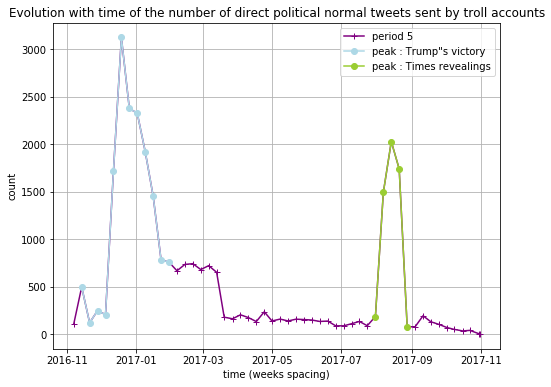

In [93]:
plt.figure(figsize=(8,6))

# /!\ occured the 8th of November 2016 => we keep counts even for January 2017 since the investiture occurs in 2017 and 
# the transition time between the efficient transfer power was a really 'hectic' time
peak_victory = political_normal_dates_w_p5_pd[(political_normal_dates_w_p5_pd.time>="2016-11-08") & (political_normal_dates_w_p5_pd.time<="2017-01-31")]

# /!\ Times' revealings
peak_gate = political_normal_dates_w_p5_pd[(political_normal_dates_w_p5_pd.time>="2017-07-25") & (political_normal_dates_w_p5_pd.time<="2017-08-31")]

plt.plot(political_normal_dates_w_p5_pd["time"],political_normal_dates_w_p5_pd["count"],color="purple",marker='+')
plt.plot(peak_victory["time"],peak_victory["count"],color="lightblue",marker='o')
plt.plot(peak_gate["time"],peak_gate["count"],color="yellowgreen",marker='o')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 5','peak : Trump"s victory','peak : Times revealings'],loc=1);

In order to be sure what for the second peak stands for we investigate its content : 

In [94]:
# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_event_p5_query = """ SELECT * 
                                       FROM political_normal_tweets_p5_sql 
                                       WHERE tweet_time>="2017-07-25" AND tweet_time<="2017-08-20"
                                       ORDER BY retweet_count DESC
                                       LIMIT 10 
                                    """
political_normal_event_p5_df = spark.sql(political_normal_event_p5_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_event_p5_pd = political_normal_event_p5_df.toPandas()

In [95]:
# print troll tweet_texts (not all relevant)
for elem in political_normal_event_p5_pd.tweet_text:
    print(elem)

JULIAN ASSANGE: I investigated both presidential candidates — Hillary was the only one with corrupt ties to Russia https://t.co/MVVPkLORTb
Acosta just asked Trump why he isn't taking more questions.  Trump:  I like real news, not fake news, and you are fake news.  Priceless! 😄 https://t.co/MBsUQS7Q8L
RT lowt3ch: Soros funded media matters is working with Facebook and Twitter to kill pro trump articles https://t.co/zwDCm4to59
President Trump calling Jim Acosta/CNN fake news is officially the best thing I've seen this week.  Cry baby Jim, cry!
Шериф с помощниками пытают задержанного (т.е. это даже не заключённый). Ашленд Сити, штат Теннесси, самая демократичная страна в мире https://t.co/Rah6Eohs8K
So CNN fired Jeffrey Lord for tweets but did nothing about Philip Mudd making threats against President trump on live TV? https://t.co/HZ6Tul09Bj
"""The problems that are facing our nation has no color. We want jobs. We want economic opportunities. We want closed borders""~ @brunelldonald http

Those tweets are reactions about that "*scandale*" earlier in 2017 about *Trump's* collaboration with Russia and his false statements on social medias. 

Looking at the global timeline of events during the campaign : around July 2017 8th, Times revealed (accused) *Trump* had been negociating with russian contacts in Trump's tower. It was proven 6 months later to be true but didn't fail to attract a lot of mediatic buzz. As the *tweet_texts* mention it there was also *Comey*'s gate (FBI former director) ! 

Trolls here are just using the most basic technique : ***bad faith*** ! 

The most retweeted tweets speak for themselves : 

        - Comey is a liar and shouldn't investigate about Trump's legitimacy. 
        - Hillary is the only one corrupted w/ russians. 
        - To Trump, journalist Acosta is "fake news" (it launched a new trend by the way)

----------------------------------------------------------------------

#### CONCLUSION 
@comment